In [1]:
import torchvision
from torchvision import datasets, models, transforms
import torch.utils.data as utils
from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import time
import copy
from torch.optim import lr_scheduler
import os
from PIL import Image, ImageEnhance
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd 
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

### Boilerpalte

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [3]:
# # First, look at everything.
# from subprocess import check_output
# print(check_output(["ls", "./data/combined_dataset/combined"]).decode("utf8"))

In [4]:
class Config():
    # training_dir = "./data/combined_dataset/combined"
    # testing_dir = "./data/combined_dataset/combined"
    # training_csv="./data/combined_dataset/train_data.csv"
    # testing_csv="./data/combined_dataset/test_data.csv"

    training_dir = "./sign_data/sign_data/train"
    testing_dir = "./sign_data/sign_data/test"
    training_csv="./sign_data/sign_data/train_data.csv"
    testing_csv="./sign_data/sign_data/test_data.csv"

    
    train_batch_size = 48
    train_number_epochs = 6

In [5]:
# training_dir="./data/combined_dataset/combined"
# training_csv="./data/combined_dataset/train_data.csv"
# testing_csv="./data/combined_dataset/test_data.csv"
# testing_dir="./data/combined_dataset/combined"

training_dir="./sign_data/sign_data/train"
training_csv="./sign_data/sign_data/train_data.csv"
testing_csv="./sign_data/sign_data/test_data.csv"
testing_dir="./sign_data/sign_data/test"

In [6]:
RESCALE_SIZE = 224
DATA_MODES = ['train', 'vis', 'test']

In [7]:
class SiameseNetworkDataset():
    
    def __init__(self,training_csv=None,training_dir=None,transform=None):
        # used to prepare the labels and images path
        self.training_df=pd.read_csv(training_csv)
        self.training_df.columns =["image1","image2","label"]
        self.training_dir = training_dir    
        self.transform = transform


    def __getitem__(self,index):
        
        # getting the image path
        image1_path=os.path.join(self.training_dir,self.training_df.iat[index,0])
        image2_path=os.path.join(self.training_dir,self.training_df.iat[index,1])
        
        # Loading the image
        img0 = Image.open(image1_path).convert('L').convert('RGB')
        img1 = Image.open(image2_path).convert('L').convert('RGB')
        
        img0 = ImageEnhance.Contrast(img0).enhance(3)
        img1 = ImageEnhance.Contrast(img1).enhance(3)

        # print(image1_path, image2_path)
        img0.load()
        img1.load()

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
            
        return img0, img1 , torch.from_numpy(np.array([int(self.training_df.iat[index,2])],dtype=np.float32))
    
    def __len__(self):
        return len(self.training_df)

In [8]:
transform = transforms.Compose([
              # transforms.Resize((RESCALE_SIZE,RESCALE_SIZE)),
            #   transforms.RandomHorizontalFlip(),
              # transforms.Resize((RESCALE_SIZE,RESCALE_SIZE)),
      

              # transforms.RandomRotation(degrees = 10, fill=255),
            #   transforms.RandomRotation(degrees = 20),
              transforms.Pad((50,50), fill=(255,255,255), padding_mode='constant'),
              # transforms.RandomRotation(degrees = 10, fill=255),
            # transforms.RandomAffine(degrees=(-10, 10), translate=None, scale=None, shear=(-10,10), resample=False, fillcolor=(255,255,255)),
              # transforms.RandomResizedCrop(RESCALE_SIZE, scale=(0.95, 1.05)),
              transforms.Resize((RESCALE_SIZE,RESCALE_SIZE)),
              # transforms.RandomResizedCrop(RESCALE_SIZE, scale=(0.9, 1.4)),
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])

In [9]:
siamese_dataset = SiameseNetworkDataset(training_csv,training_dir,transform=transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


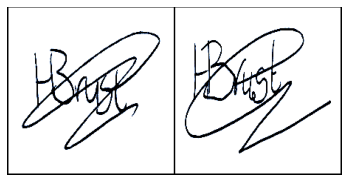

[[1.]]


In [10]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=1)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

### ResNet Siamese

In [13]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        self.resnet = models.resnet18(pretrained=False)
        set_parameter_requires_grad(self.resnet)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
                # nn.Linear(num_ftrs, 16),
                nn.Linear(num_ftrs, 512),
                nn.ReLU(inplace=True),
                nn.Dropout2d(p=0.5),
                nn.Linear(512, 128),
                nn.ReLU(inplace=True),
                # nn.Dropout2d(p=0.5),
                nn.Linear(128,2)
            )
        
    def forward_once(self, x):
        output = self.resnet(x)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2


In [14]:
def set_parameter_requires_grad(model):
    for param in model.parameters():
        param.requires_grad = True

### Loss

In [15]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean(
            (1-label) * torch.pow(euclidean_distance, 2) + 
            (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
                )

        return loss_contrastive

### Train

In [16]:
if torch.cuda.is_available():
    print('Yes')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Yes


In [17]:
# def train():
#     counter = []
#     loss_history = [] 
#     iteration_number= 0
    
#     for epoch in range(0,Config.train_number_epochs):
#         for i, data in enumerate(train_dataloader,0):
#             img0, img1 , label = data
#             img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
#             optimizer.zero_grad()
#             output1, output2 = net(img0,img1)
#             loss_contrastive = criterion(output1,output2,label)
#             loss_contrastive.backward()
#             optimizer.step()
#             if i %50 == 0 :
#                 print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
#                 iteration_number +=10
#                 counter.append(iteration_number)
#                 loss_history.append(loss_contrastive.item())
#     return net

In [18]:
def fit_epoch(net, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for i, data in enumerate(train_loader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1, output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()


        running_loss += loss_contrastive.item() * data[0].size(0)
        processed_data += data[0].size(0)
              
    train_loss = running_loss / processed_data

    return train_loss

In [19]:
def train(train_files, net, epochs, batch_size):
    train_dataloader = DataLoader(train_files,
                        shuffle=True,
                        num_workers=4,
                        batch_size=batch_size)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = optim.AdamW(net.parameters(), lr=0.02)
        scheduler = StepLR(opt, step_size=1, gamma=0.5)
        criterion = ContrastiveLoss()

        for epoch in range(epochs):
            train_loss = fit_epoch(net, train_dataloader, criterion, opt)
            print("loss", train_loss)
            
            scheduler.step()
            history.append((train_loss))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss))
            
    return history

In [20]:
net = SiameseNetwork().cuda()
train_dataset = SiameseNetworkDataset(training_csv=Config.training_csv, training_dir=Config.training_dir, transform=transform)

In [19]:
history = train(train_dataset, net=net, epochs=Config.train_number_epochs, batch_size=Config.train_batch_size)

epoch:  17%|█▋        | 1/6 [07:30<37:31, 450.24s/it]loss 1.668558870767422

Epoch 001 train_loss: 1.6686
epoch:  33%|███▎      | 2/6 [15:14<30:17, 454.36s/it]loss 1.15637359300119

Epoch 002 train_loss: 1.1564
epoch:  50%|█████     | 3/6 [22:42<22:37, 452.53s/it]loss 1.1514970715922852

Epoch 003 train_loss: 1.1515
epoch:  67%|██████▋   | 4/6 [30:04<14:59, 449.51s/it]loss 1.1531312426059726

Epoch 004 train_loss: 1.1531
epoch:  83%|████████▎ | 5/6 [37:10<07:22, 442.37s/it]loss 1.1528328590571841

Epoch 005 train_loss: 1.1528
epoch: 100%|██████████| 6/6 [44:43<00:00, 447.20s/it]loss 1.1532856846903707

Epoch 006 train_loss: 1.1533



In [20]:
# torch.save(net.state_dict(), "model.pt")
# print("Model Saved Successfully")

In [21]:
# # Load the saved model
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = SiameseNetwork().to(device)
# model.load_state_dict(torch.load("model.pt"))

In [22]:
transform = transforms.Compose([
              transforms.Resize((RESCALE_SIZE,RESCALE_SIZE)),
            #   transforms.RandomHorizontalFlip(),
            #   transforms.RandomRotation(degrees = 20),
            #   transforms.RandomRotation(degrees = 20),
            #   transforms.RandomRotation(degrees = 10),
            #   transforms.RandomResizedCrop(RESCALE_SIZE, scale=(0.7, 1.0)),
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])

In [23]:
test_dataset = SiameseNetworkDataset(training_csv=testing_csv,training_dir=testing_dir,                                     transform=transform)

test_dataloader = DataLoader(test_dataset,num_workers=6,batch_size=1,shuffle=True)

In [24]:
from tqdm import tqdm

In [25]:
targets = []
predictions = []
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])
threshhold = torch.FloatTensor([0.8]).cuda()
for i, data in enumerate(tqdm(test_dataloader)):
    x0, x1 , label = data
    output1,output2 = net(x0.to(device),x1.to(device))
    eucledian_distance = F.pairwise_distance(output1, output2)
    if label==list_0:
        targets.append(0)
    else:
        targets.append(1)
    
    if eucledian_distance <= threshhold:
        predictions.append(0)
    else:
        predictions.append(1)

100%|██████████| 5747/5747 [01:15<00:00, 75.85it/s]


In [26]:
from sklearn.metrics import f1_score

In [27]:
n_predictions = np.array(predictions)
n_targets = np.array(targets)
(n_predictions == n_targets).astype('int').sum()/len(n_predictions)

0.5065251435531581

In [28]:
f1_score(n_targets, n_predictions, average='weighted')

0.5064205332984898

In [29]:
# TPR
n_predictions.astype('int').sum()/np.logical_and((n_predictions == 1.0),(n_targets == 1.0)).astype('int').sum()

1.9115776081424936

In [30]:
# FPR
n_false_predictions = (np.array(predictions) == 0.0).astype('int')
n_false_targets = (np.array(targets) == 0.0).astype('int')
n_false_predictions.astype('int').sum()/n_false_targets.astype('int').sum()

0.9891774891774892

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


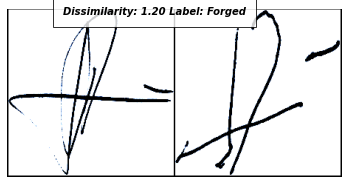

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


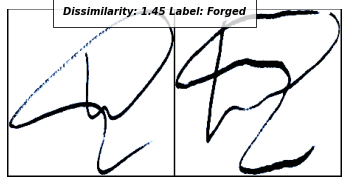

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


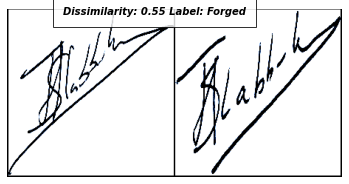

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


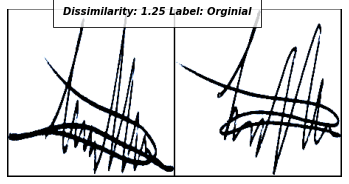

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


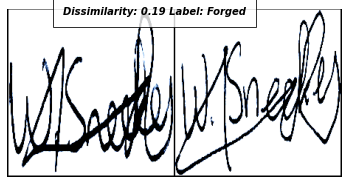

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


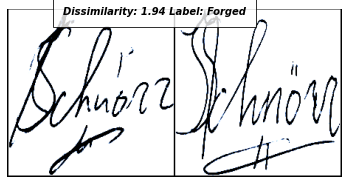

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


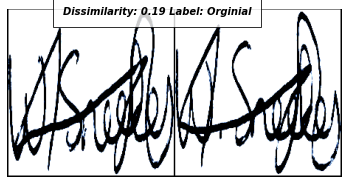

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


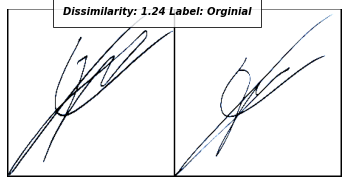

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


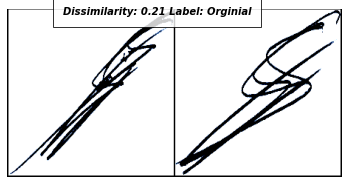

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


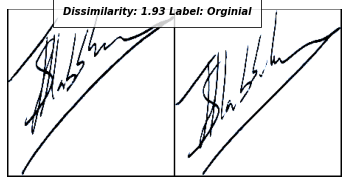

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


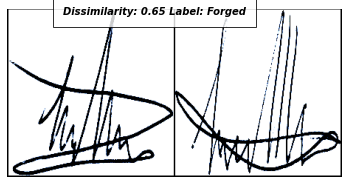

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


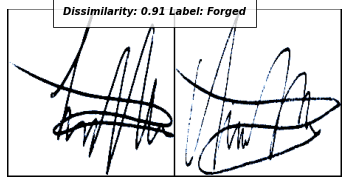

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


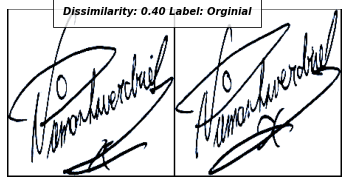

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


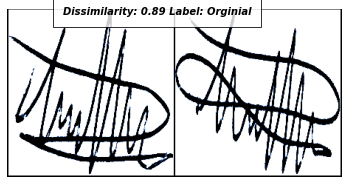

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


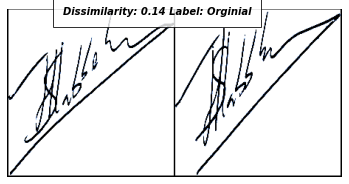

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


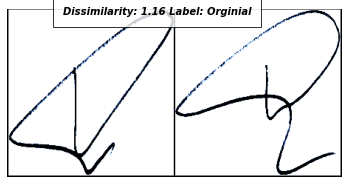

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


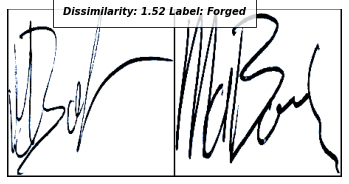

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


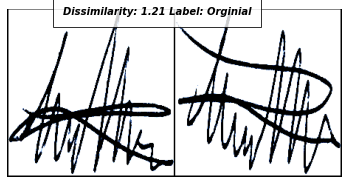

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


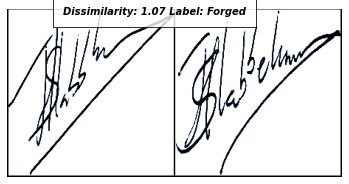

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


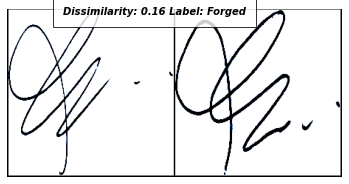

In [31]:
# Print the sample outputs to view its dissimilarity
counter=0
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])
for i, data in enumerate(test_dataloader,0): 
  x0, x1 , label = data
  concatenated = torch.cat((x0,x1),0)
  output1,output2 = net(x0.to(device),x1.to(device))
  eucledian_distance = F.pairwise_distance(output1, output2)
  if label==list_0:
    label="Orginial"
  else:
    label="Forged"
  imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f} Label: {}'.format(eucledian_distance.item(),label))
  counter=counter+1
  if counter ==20:
     break

In [ ]:
# Gridsearch границы forged/original
# tiplet loss
# accuracy
# concat datasets

Paper Reference: https://arxiv.org/pdf/1707.02131.pdf

Public kernel: https://www.kaggle.com/robinreni/signature-classification-using-siamese-pytorch 